<a href="https://colab.research.google.com/github/AliceKitchkin/Forecasting-Rossmann-Store-Sales/blob/main/Forecasting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vorhersagen von Rossmann Store Sales

## Inhaltsverzeichnis <a id="0"></a> <br>
* [Einleitung](#1) <font color='green'>Alice</font>
* [Package- und Datenimport](#2) <font color='green'>Alice</font>
* [Deskriptive Analyse](#3)
    * [Datenüberblick](#3.1) <font color='green'>Alice</font>
    * [Datentypen](#3.2) <font color='orange'>Alice</font>
    * [Betrachtung der Verteilung](#3.3) <font color='orange'>Alice</font>
    * [Analyse der Kategorischen Variablen](#3.4) <font color='red'>Not started</font>
    * [Zeitreihenanalyse](#3.5) <font color='green'>Niklas</font>
    * [Korrelationen](#3.6) <font color='orange'>In Progress</font>
    * [Fehlende Werte und Ausreißer:](#3.7) <font color='orange'>In Progress</font>
* [Daten anpassen](#4) <font color='red'>Not started</font>
* [Geeignete Merkmale](#4) <font color='red'>Not started</font>
* [ML Verfahren 1](#5) <font color='red'>Not started</font>
* [ML Verfahren 2](#6) <font color='red'>Not started</font>
* [Vergleich](#7) <font color='red'>Not started</font>

## 1. Einleitung <a id="1"></a> <br>

Dieses Jupyter Notebook dokumentiert unser Projekt für das Modul Data Mining, in dem wir die Verkaufszahlen der Rossmann-Filialen vorhersagen. Diese Aufgabe basiert auf dem Rossmann Store Sales Datensatz von [Kaggle.com](https://www.kaggle.com/competitions/rossmann-store-sales/overview), der umfangreiche Verkaufsdaten von über 1000 Filialen enthält. 

Alle verwendeten Quellen werden entsprechend referenziert. Die Nutzung von KI-gestützten Tools ist für dieses Projekt erlaubt und alle Schritte, einschließlich der Prompts, werden dokumentiert.

## 2. Package- und Datenimport <a id="2"></a> <br>

In [390]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white') # Hintergrund der Plots

In [391]:
# unzip train-file, to large for github
# train.csv is included in .gitignore
with zipfile.ZipFile("./data/train.zip", "r") as zip:
    zip.extract('train.csv', "./data/")

In [392]:
# Maximale Anzahl an Spalten und Zeilen, beim anzeigen von Dataframes
pd.options.display.max_columns = None
pd.options.display.max_rows = 50

## 3. Deskriptive Analyse <a id="3"></a> <br>

Der Rossmann Store Sales-Datensatz enthält historische Verkaufsdaten für 1.115 Rossmann-Filialen. Er besteht aus drei CSV-Dateien:

- train.csv: Historische Daten einschließlich Verkäufe
- test.csv: Historische Daten ohne Verkäufe (für die Vorhersage)
- store.csv: Zusätzliche Informationen über die Filialen

Im ersten Schritt werden die Spalten der Datensätze umbenannt und in Variablen gespeichert.


In [393]:
# Spalten umbennen, damit alles einheitlich auf deutsch ist
train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",
                                                        "DayOfWeek":"Wochentag",
                                                        "Date":"Datum",
                                                        "Sales":"Umsatz",
                                                        "Customers":"Kundenanzahl",
                                                        "Open":"Geoeffnet",
                                                        "Promo":"Aktionstag",
                                                        "StateHoliday":"Feiertag",
                                                        "SchoolHoliday":"Schulferien"})

test_original = pd.read_csv("./data/test.csv").rename(columns={"Id":"ID",
                                                      "Store":"Filiale",
                                                      "DayOfWeek":"Wochentag",
                                                      "Date":"Datum",
                                                      "Open":"Geoeffnet",
                                                      "Promo":"Aktionstag",
                                                      "StateHoliday":"Feiertag",
                                                      "SchoolHoliday":"Schulferien"})

store_original = pd.read_csv("./data/store.csv").rename(columns={"Store":"Filiale",
                                                        "StoreType":"Filialentyp",
                                                        "Assortment":"Sortiment",
                                                        "CompetitionDistance":"Wettbewerberentfernung",
                                                        "CompetitionOpenSinceMonth":"Wettbewerber_Eroeffnet_seit_Monat",
                                                        "CompetitionOpenSinceYear":"Wettbewerber_Eroeffnet_seit_Jahr",
                                                        "Promo2": "Teilnahme_Langzeitaktion",
                                                        "Promo2SinceWeek":"Aktion_seit_Woche",
                                                        "Promo2SinceYear":"Aktion_seit_Jahr",
                                                        "PromoInterval":"Aktionsmonate"})

# Um in einem späteren Zeitpunkt auf die originalen Datensätze zugreifen zu können, werden diese hier separat gespeichert.
# Außerdem werden die Datensätze _train_original_ und _store_original_ über die Spalte _Filiale_ verbunden und im neuen Datensatz 
# _train_x_store_ gespeichert. Für den Datensatz _test_original_ wird das gleiche Prozedere angewandt.
train = train_original
test = test_original
store = store_original

train_x_store = pd.merge(train, store)
test_x_store = pd.merge(test, store)

C:\Users\AliceKitchkin\AppData\Local\Temp\ipykernel_22760\2068288085.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",


### 3.1 Datenüberblick <a id="3.1"></a> <br>

Kurzbeschreibung der Spalten der Train-, Test- und Store-Datensätze.

| Spalte                        | Umbenennung                           | Beschreibung                                                         |
|-------------------------------|---------------------------------------|----------------------------------------------------------------------|
| `Id`                          | `ID`                                  | Eindeutige ID für jede Filiale und jedes Datumspaar im Testdatensatz.|
| `Store`                       | `Filiale`                             | Eindeutige ID für jede Filiale.|
| `Sales`                       | `Wochentag`                           | Wochentag als Zahl von 1 (Montag) bis 7 (Sonntag) |
| `Date`                        | `Datum`                               | Datum (im "yyyy-mm-dd" Format) |
| `Sales`                       | `Umsatz`                              | Umsatz an einem bestimmten Tag (zu prognostizierendes Ziel).|
| `Customers`                   | `Kundenanzahl`                        | Anzahl der Kunden an einem bestimmten Tag.|
| `Open`                        | `Geoeffnet`                           | Indikator, ob die Filiale geöffnet war (0 = geschlossen, 1 = geöffnet).|
| `Promo`                       | `Aktionstag`                          | Gibt an, ob ein Geschäft an diesem Tag eine Werbeaktion durchführt.|
| `StateHoliday`                | `Feiertag`                            | Feiertagstyp (a = öffentlicher Feiertag, b = Osterfeiertag, c = Weihnachten, 0 = keiner).|
| `SchoolHoliday`               | `Schulferien`                         | Gibt an, ob die Filiale von Schulschließungen betroffen war.|
| `StoreType`                   | `Filialtyp`                           | Unterscheidet zwischen 4 verschiedenen Filialmodellen (a, b, c, d).|
| `Assortment`                  | `Sortiment`                           | Beschreibt das Sortiment (a = grundlegend, b = extra, c = erweitert).|
| `CompetitionDistance`         | `Wettbewerberentfernung`              | Entfernung in Metern zum nächsten Wettbewerbergeschäft.|
| `CompetitionOpenSinceMonth`   | `Wettbewerber_Eroeffnet_seit_Monat`   | Gibt den Monat an, in dem der nächste Wettbewerber eröffnet wurde.|
| `CompetitionOpenSinceYear`    | `Wettbewerber_Eroeffnet_seit_Jahr`    | Gibt das Jahr an, in dem der nächste Wettbewerber eröffnet wurde.|
| `Promo2`                      | `Teilnahme_Langzeitaktion`            | Promo2 ist eine fortlaufende und aufeinanderfolgende Werbeaktion für einige Geschäfte (0 = nein, 1 = ja).|
| `Promo2SinceWeek`             | `Aktion_seit_Woche`                   | Beschreibt die Kalenderwoche, in der das Geschäft an Promo2 teilnimmt.|
| `Promo2SinceYear`             | `Aktion_seit_Jahr`                    | Beschreibt das Jahr, in der das Geschäft an Promo2 teilnimmt.|
| `PromoInterval`               | `Aktionsmonate`                       | Beschreibt die aufeinanderfolgenden Intervalle, in denen Promo2 gestartet wird (z. B. "Feb, Mai, Aug, Nov").|

**Train-Datensatz Datenüberblick**

In [394]:
display(train.head())

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


**Test-Datensatz Datenüberblick**

In [395]:
display(test.head())

,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


**Store-Datensatz Datenüberblick**

In [396]:
display(store.head())

,Filiale,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 3.2 Datentypen <a id="3.2"></a> <br>

Neue Spalten
| Originale Spalte              | Neue Spalte                           | Beschreibung                                                              |
|-------------------------------|---------------------------------------|---------------------------------------------------------------------------|
| `Datum`                          | `Tag`                              | Gibt den Tag aus der ursprünglichen Spalte Datum an (von 1 bis 31).       |
| `Datum`                          | `Monat`                            | Gibt den Monat aus der ursprünglichen Spalte Datum an (von 1 bis 12).     |
| `Datum`                          | `Jahr`                             | Gibt das Jahr aus der ursprünglichen Spalte Datum an.             	    |
| `Datum`                          | `Quartal`                          | Gibt das Quartal aus der ursprünglichen Spalte Datum an (von 1 bis 4).    |

In [397]:
# Datentypen vor Korrektur
train_x_store.dtypes

Filiale                                int64
Wochentag                              int64
Datum                                 object
Umsatz                                 int64
Kundenanzahl                           int64
Geoeffnet                              int64
Aktionstag                             int64
Feiertag                              object
Schulferien                            int64
Filialentyp                           object
Sortiment                             object
Wettbewerberentfernung               float64
Wettbewerber_Eroeffnet_seit_Monat    float64
Wettbewerber_Eroeffnet_seit_Jahr     float64
Teilnahme_Langzeitaktion               int64
Aktion_seit_Woche                    float64
Aktion_seit_Jahr                     float64
Aktionsmonate                         object
dtype: object

In [398]:
# bestehende Spalten anpassen
train_x_store["Datum"] = pd.to_datetime(train_x_store["Datum"])
train_x_store["Wochentag"] = train_x_store["Datum"].dt.weekday

# neue Spalten hinzufügen
train_x_store["Tag"] = train_x_store["Datum"].dt.day
train_x_store["Monat"] = train_x_store["Datum"].dt.month
train_x_store["Jahr"] = train_x_store["Datum"].dt.year
train_x_store["Quartal"] = train_x_store["Datum"].dt.quarter

In [399]:
# Datentypen nach Korrektur
display(train_x_store.dtypes)

Filiale                                       int64
Wochentag                                     int32
Datum                                datetime64[ns]
Umsatz                                        int64
Kundenanzahl                                  int64
Geoeffnet                                     int64
Aktionstag                                    int64
Feiertag                                     object
Schulferien                                   int64
Filialentyp                                  object
Sortiment                                    object
Wettbewerberentfernung                      float64
Wettbewerber_Eroeffnet_seit_Monat           float64
Wettbewerber_Eroeffnet_seit_Jahr            float64
Teilnahme_Langzeitaktion                      int64
Aktion_seit_Woche                           float64
Aktion_seit_Jahr                            float64
Aktionsmonate                                object
Tag                                           int32
Monat       

### 3.2 Betrachtung der Verteilung <a id="3.2"></a> <br>

**Train_x_Store-Datensatz**

- Deskriptive Statistiken: Mittelwert, Median, Minimum, Maximum, Standardabweichung, Quartile (für numerische Variablen).
- Verteilung der Daten: Histogramme, Boxplots oder Dichteplots zur Visualisierung der Verteilung der numerischen Variablen.

In [400]:
describe = train_x_store.describe(include='all')
dtypes = pd.DataFrame(test.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien,Umsatz,Kundenanzahl,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate,Tag,Monat,Jahr,Quartal
dtypes,int64,int64,int64,object,float64,int64,object,int64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,NaN,1017209.0,1017209.0,1017209,1017209.0,1017209.0,1017209,1017209.0,1.017209e+06,1.017209e+06,1017209,1017209,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,509178,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct",NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,855087,NaN,NaN,NaN,551627,537445,NaN,NaN,NaN,NaN,NaN,NaN,293122,NaN,NaN,NaN,NaN
mean,NaN,558.429727,2.998341,2014-04-11 01:30:42.846061824,0.830107,0.381515,NaN,0.178647,5.773819e+03,6.331459e+02,NaN,NaN,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,NaN,1.570279e+01,5.846762e+00,2.013832e+03,2.294252e+00
min,NaN,1.0,0.0,2013-01-01 00:00:00,0.0,0.0,NaN,0.0,0.000000e+00,0.000000e+00,NaN,NaN,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,NaN,1.000000e+00,1.000000e+00,2.013000e+03,1.000000e+00
25%,NaN,280.0,1.0,2013-08-17 00:00:00,1.0,0.0,NaN,0.0,3.727000e+03,4.050000e+02,NaN,NaN,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,NaN,8.000000e+00,3.000000e+00,2.013000e+03,1.000000e+00
50%,NaN,558.0,3.0,2014-04-02 00:00:00,1.0,0.0,NaN,0.0,5.744000e+03,6.090000e+02,NaN,NaN,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,NaN,1.600000e+01,6.000000e+00,2.014000e+03,2.000000e+00
75%,NaN,838.0,5.0,2014-12-12 00:00:00,1.0,1.0,NaN,0.0,7.856000e+03,8.370000e+02,NaN,NaN,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,NaN,2.300000e+01,8.000000e+00,2.014000e+03,3.000000e+00


### 3.3 Analyse der Kategorischen Variablen <a id="3.3"></a> <br>

- Häufigkeitsverteilungen: Anzahl der Vorkommen jeder Kategorie (z.B. Anzahl der Filialen, Wochentage, Promotion-Typen).
- Balkendiagramme: Grafische Darstellung der Häufigkeiten.

### 3.4 Zeitreihenanalyse <a id="3.4"></a> <br>

- Trendanalyse: Darstellung des Umsatzes über die Zeit, um Trends, saisonale Muster oder Zyklen zu identifizieren.
- Saisonale Muster: Analyse von Wochen-, Monats- und Jahresmustern.

### 3.5 Korrelationsanalyse <a id="3.5"></a> <br>

- Korrelationsmatrix: Untersuchung der Beziehungen zwischen numerischen Variablen, z.B. Umsatz und Anzahl der Kunden.
- Heatmaps: Visuelle Darstellung der Korrelationen.

In [401]:
train_x_store.head()

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate,Tag,Monat,Jahr,Quartal
0,1,4,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015,3
1,1,3,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,30,7,2015,3
2,1,2,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,29,7,2015,3
3,1,1,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,28,7,2015,3
4,1,0,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,27,7,2015,3


Die Korrelationsmatrix beinhaltet alle numerischen Spalten aus dem _train_x_store_ Datensatz. Dabei wird bei der Pearson-Korrelation mit binären Variablen genauso wie mit kontinuierlichen Variablen umgegangen.

In [402]:
store_id = store["Filiale"].sample(n=1).values[0]

sample = train_x_store[train_x_store["Filiale"]==store_id].copy()
display(sample.head())

# Spalten mit numerischen Werten (Strings und kategorische Werte ausgeschlossen)
sample_only_nr = sample.select_dtypes(include=['number'])
display(sample_only_nr.head())

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate,Tag,Monat,Jahr,Quartal
466458,512,4,2015-07-31,8548,1812,1,1,0,0,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec",31,7,2015,3
466459,512,3,2015-07-30,6606,1527,1,1,0,0,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec",30,7,2015,3
466460,512,2,2015-07-29,6454,1412,1,1,0,0,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec",29,7,2015,3
466461,512,1,2015-07-28,5944,1494,1,1,0,0,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec",28,7,2015,3
466462,512,0,2015-07-27,6694,1476,1,1,0,0,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec",27,7,2015,3


,Filiale,Wochentag,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Schulferien,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Tag,Monat,Jahr,Quartal
466458,512,4,8548,1812,1,1,0,590.0,NaN,NaN,1,5.0,2013.0,31,7,2015,3
466459,512,3,6606,1527,1,1,0,590.0,NaN,NaN,1,5.0,2013.0,30,7,2015,3
466460,512,2,6454,1412,1,1,0,590.0,NaN,NaN,1,5.0,2013.0,29,7,2015,3
466461,512,1,5944,1494,1,1,0,590.0,NaN,NaN,1,5.0,2013.0,28,7,2015,3
466462,512,0,6694,1476,1,1,0,590.0,NaN,NaN,1,5.0,2013.0,27,7,2015,3


,Filiale,Wochentag,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Schulferien,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Tag,Monat,Jahr,Quartal
Filiale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wochentag,NaN,1.000000,0.078007,-0.145550,0.000087,-0.392897,-0.209175,NaN,NaN,NaN,NaN,NaN,NaN,-0.000502,-0.003673,0.002491,-0.008611
Umsatz,NaN,0.078007,1.000000,0.864966,0.530546,0.195533,-0.028087,NaN,NaN,NaN,NaN,NaN,NaN,-0.050885,0.068579,0.485700,0.039772
Kundenanzahl,NaN,-0.145550,0.864966,1.000000,0.643915,0.273163,-0.073344,NaN,NaN,NaN,NaN,NaN,NaN,-0.007060,0.086481,0.440681,0.062565
Geoeffnet,NaN,0.000087,0.530546,0.643915,1.000000,-0.001991,0.030949,NaN,NaN,NaN,NaN,NaN,NaN,0.085449,0.176294,0.124214,0.138436
Aktionstag,NaN,-0.392897,0.195533,0.273163,-0.001991,1.000000,0.075153,NaN,NaN,NaN,NaN,NaN,NaN,-0.078230,-0.027265,0.024781,-0.024369
Schulferien,NaN,-0.209175,-0.028087,-0.073344,0.030949,0.075153,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.021852,0.061554,-0.075511,0.053268
Wettbewerberentfernung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wettbewerber_Eroeffnet_seit_Monat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wettbewerber_Eroeffnet_seit_Jahr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


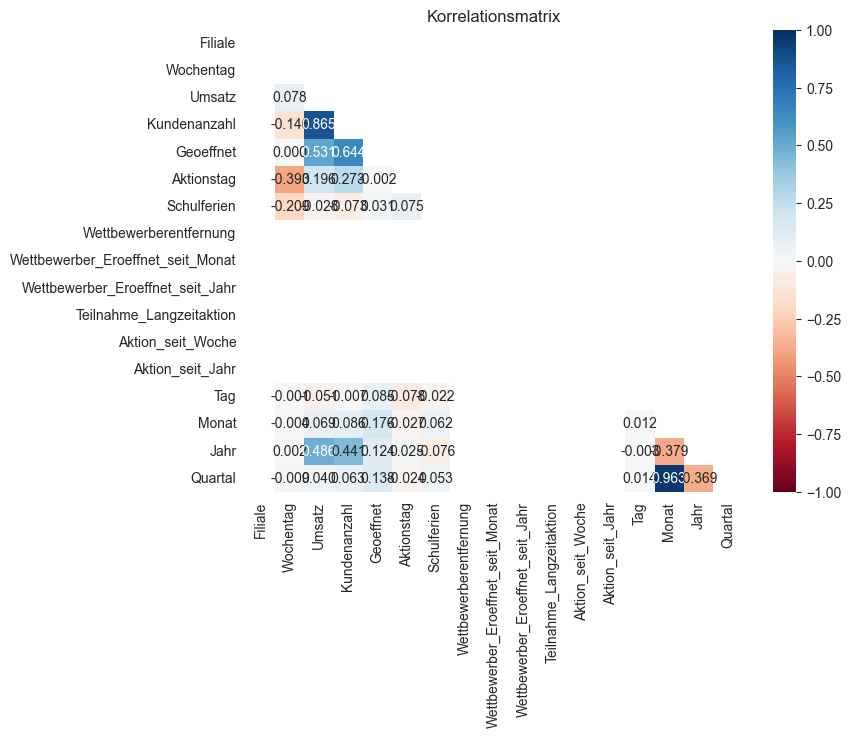

In [403]:
# Korrelationsmatrix nach Pearson-Verfahren erstellen
corr_matrix = sample_only_nr.corr("pearson")
display(corr_matrix)

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(8,6))
plot = sns.heatmap(corr_matrix, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Korrelationsmatrix")
plt.show()

### 3.6 Fehlende Werte und Ausreißer <a id="3.6"></a> <br>

In diesem Kapitel identifizieren wir fehlende Werte und Ausreißer in den Daten an. Ausreißer definieren wir als ungegwöhnlich hohe oder niedrige Werte, die nicht dem allgemeinen Muster folgen.

In [404]:
train_x_store.isnull().sum()

Filiale                                   0
Wochentag                                 0
Datum                                     0
Umsatz                                    0
Kundenanzahl                              0
Geoeffnet                                 0
Aktionstag                                0
Feiertag                                  0
Schulferien                               0
Filialentyp                               0
Sortiment                                 0
Wettbewerberentfernung                 2642
Wettbewerber_Eroeffnet_seit_Monat    323348
Wettbewerber_Eroeffnet_seit_Jahr     323348
Teilnahme_Langzeitaktion                  0
Aktion_seit_Woche                    508031
Aktion_seit_Jahr                     508031
Aktionsmonate                        508031
Tag                                       0
Monat                                     0
Jahr                                      0
Quartal                                   0
dtype: int64

#### Fehlende Werte in Wettbewerberentfernung

Im Datensatz gibt es einige Spalten mit fehlenden Werten, welche wir uns nach und nach ansehen werden. Wir beginnen mit der Spalte _Wettbewerberentfernung_, worin 2.642 NaN-Werte gefunden wurden.

In [439]:
train_x_store[pd.isnull(train_x_store.Wettbewerberentfernung)].head()

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate,Tag,Monat,Jahr,Quartal
263244,291,4,2015-07-31,10052,973,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN,31,7,2015,3
263245,291,3,2015-07-30,9030,883,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN,30,7,2015,3
263246,291,2,2015-07-29,8204,814,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN,29,7,2015,3
263247,291,1,2015-07-28,10374,943,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN,28,7,2015,3
263248,291,0,2015-07-27,11692,1086,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN,27,7,2015,3


Wir nehmen  an, dass die Daten einfach nicht vorhanden sind und ersetzen daher die fehlenden Werte in _Wettbewerberentfernung_ mit dem Median.

In [383]:
train_x_store["Wettbewerberentfernung"].fillna(train_x_store["Wettbewerberentfernung"].median(), inplace=True)

#### Fehlende Werte in Teilnahme_Langzeitaktion, Aktion_seit_Woche, Aktion_seit_Jahr

Als nächstes sehen wir uns die Spalten _Teilnahme_Langzeitaktion_, _Aktion_seit_Woche_ und _Aktion_seit_Jahr_ an. Sofern eine Filiale an einer Langzeitaktion teilnimmt, sollten auch Monat und Jahr nicht fehlen.

In [452]:
display(train_x_store[(train_x_store.Teilnahme_Langzeitaktion==1) & (pd.isnull(train_x_store.Aktion_seit_Woche))])
display(train_x_store[(train_x_store.Teilnahme_Langzeitaktion==1) & (pd.isnull(train_x_store.Aktion_seit_Jahr))])

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate,Tag,Monat,Jahr,Quartal


,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate,Tag,Monat,Jahr,Quartal


Immer wenn eine Filiale an der Langzeitaktion teilnimmt, fehlen keine Wochen oder Jahre. Daher können wir bei keiner Teilnahme an Langzeitaktionen die fehlenden Werte durch Null ersetzen.

In [385]:
train_x_store["Aktion_seit_Woche"].fillna(0, inplace=True)
train_x_store["Aktion_seit_Jahr"].fillna(0, inplace=True)

#### 3.6.2 Ausreißer

#### Tage ohne Umsatz betrachten

Gibt es Datensätze mit 0€ Umsatz? Wenn ja, wann und wieso ist das so?

In [386]:
display(train_x_store[train_x_store.Umsatz==0.0])

kein_umsatz_anzahl = train_x_store[train_x_store.Umsatz==0.0].shape[0]

print(str(kein_umsatz_anzahl) + " von " + str(train_x_store.shape[0]) + " Zeilen (" + str(round(kein_umsatz_anzahl/train_x_store.shape[0]*100,2)) + "%) haben keinen Umsatz.")


,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate,Tag,Monat,Jahr,Quartal
5,1,6,2015-07-26,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,26,7,2015,3
12,1,6,2015-07-19,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,19,7,2015,3
19,1,6,2015-07-12,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,12,7,2015,3
26,1,6,2015-07-05,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5,7,2015,3
33,1,6,2015-06-28,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,28,6,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017182,1115,6,2013-01-27,0,0,0,0,0,0,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",27,1,2013,1
1017189,1115,6,2013-01-20,0,0,0,0,0,0,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",20,1,2013,1
1017196,1115,6,2013-01-13,0,0,0,0,0,0,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",13,1,2013,1
1017203,1115,6,2013-01-06,0,0,0,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6,1,2013,1


172871 von 1017209 Zeilen (16.99%) haben keinen Umsatz.


Wir nehmen uns eine zufällige Filiale und schauen uns an, wann kein Umsatz gemacht wurde

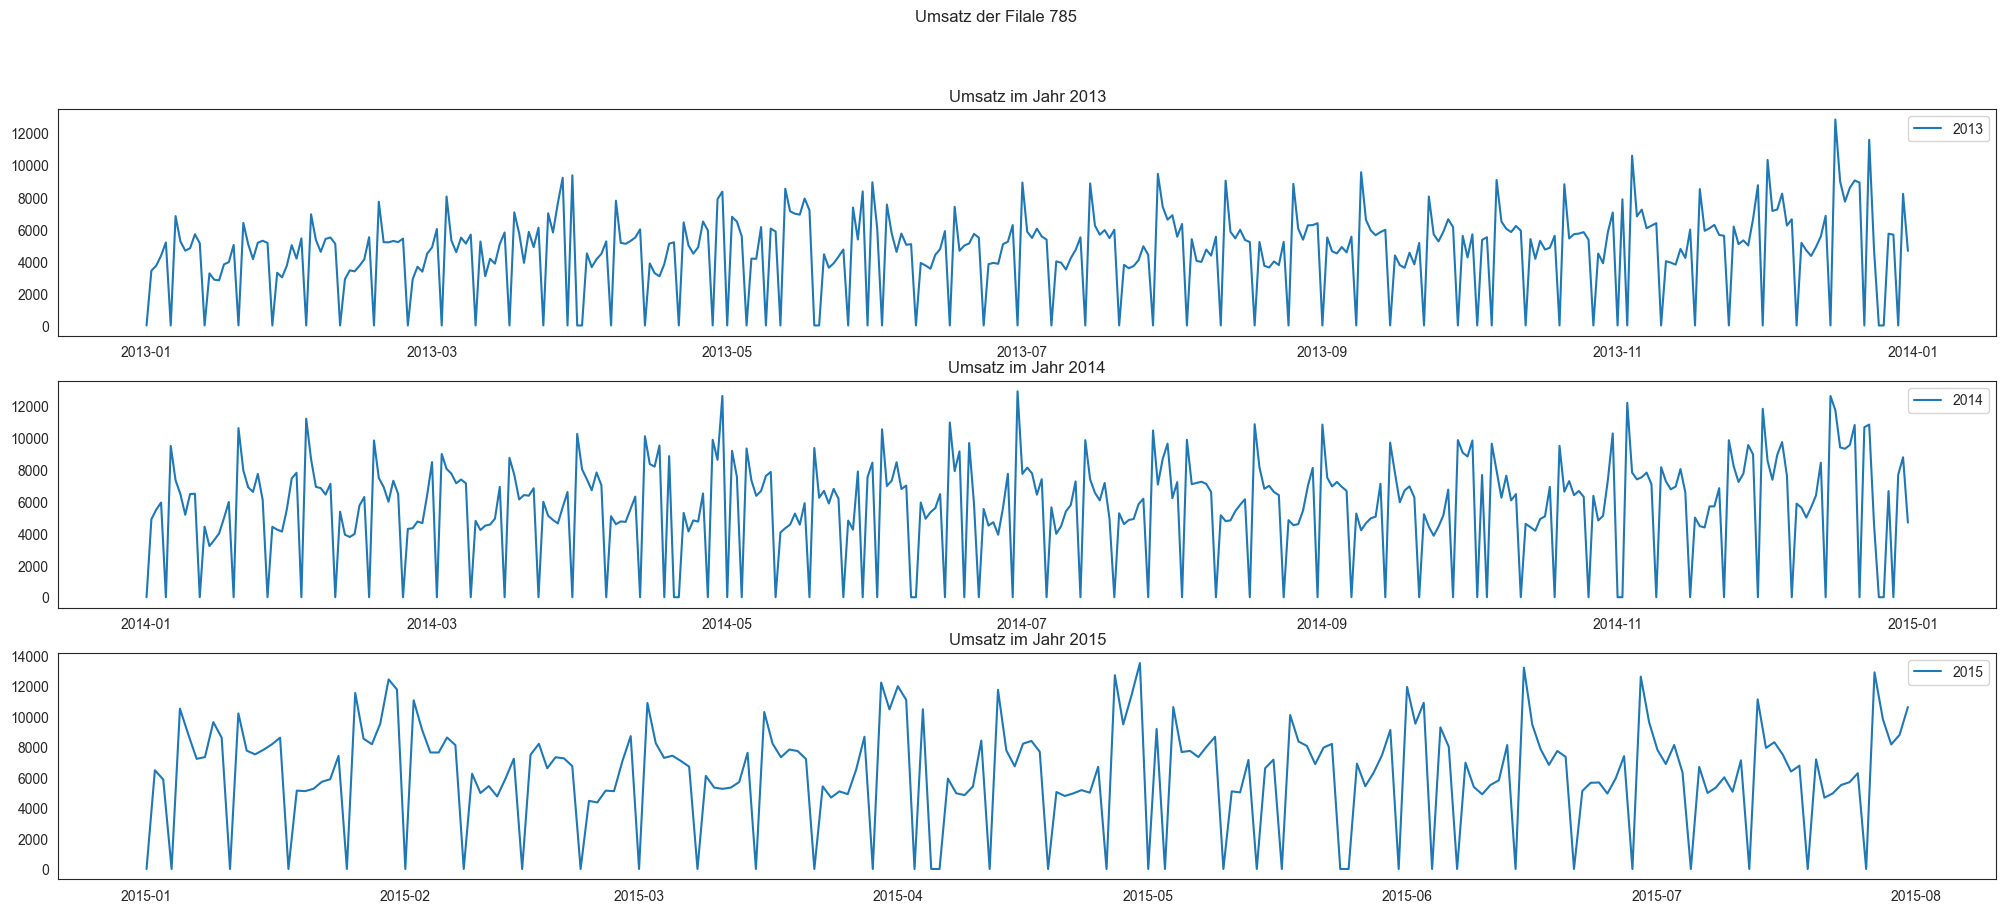

In [387]:
store_id = store["Filiale"].sample(n=1).values[0]
sample = train_x_store[train_x_store["Filiale"]==store_id].copy()
gp_sample_by_year = sample.groupby(sample["Datum"].dt.year)

fig, axs = plt.subplots(3)
fig.set(figheight = 10, figwidth = 25)
fig.suptitle(f"Umsatz der Filale {store_id}")

for id, sample_year in enumerate(gp_sample_by_year):
    axs[id].plot(sample_year[1]["Datum"], sample_year[1]["Umsatz"], label = sample_year[0])
    axs[id].set_title(f"Umsatz im Jahr {sample_year[0]}")
    axs[id].legend()

plt.show()

In [388]:
# Alle Tage, an denen kein Umsatz gemacht wurde, obwohl die Filiale geöffnet war
kein_umsatz_geoeffnet = train[(train["Umsatz"]==0) & (train["Geoeffnet"]==True)]
kein_umsatz_geoeffnet.head()

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
86825,971,5,2015-05-15,0,0,1,0,0,1
142278,674,4,2015-03-26,0,0,1,0,0,0
196938,699,4,2015-02-05,0,0,1,1,0,0
322053,708,3,2014-10-01,0,0,1,1,0,0
330176,357,1,2014-09-22,0,0,1,0,0,0


In [389]:
kein_umsatz_geoeffnet_grouped = kein_umsatz_geoeffnet.groupby(["Wochentag", "Geoeffnet"]).agg(
    Anzahl_Tage=('Umsatz', 'size'),   # Anzahl der Zeilen
    Umsatz=('Umsatz', 'sum')     # Summe der Umsätze
)

kein_umsatz_geoeffnet_grouped

,,Anzahl_Tage,Umsatz
Wochentag,Geoeffnet,,
1,1,3,0
2,1,6,0
3,1,14,0
4,1,18,0
5,1,7,0
6,1,6,0


#### Leere Werte betrachten

## Geeignete Merkmale <a id="4"></a> <br>

Definieren Sie geeignete Merkmale (Features) für die Klassifikation/Regression/Clustering. Versuchen Sie dabei, aus den bestehenden Merkmale neue abzuleiten und überlegen Sie sich zusätzliche z.B. mit externen Informationen. 

## Machine Learning Verfahren 1 <a id="5"></a> <br>

### 5.1 XXX <a id="5.1"></a> <br>

### 5.2 Modellgüte <a id="5.2"></a> <br>

## Machine Learning Verfahren 2 <a id="6"></a> <br>

## Vergleich der Machine Learning Verfahren <a id="7"></a> <br>